# Atividade 03 - Parte 01
Nesta atividade o tópicos realizados foram:

1- Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas;

2- Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade;

3- Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs. Deve ser considerado o efeito Tip-Downwash;

4- Implementar a função do modelo gaussiano;

5- Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491;

6- Plotagem e discussão dos resultados.

## 1- Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas

Utilizando os dados do EZ-AERMOD de 5 dias do verão e 5 duias do inverno e determinando sua classe com base na Classificação de Estabilidade de Pasquill.

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar os dados
data = pd.read_csv('C:\\Users\\Dell\\OneDrive\\Documentos\\GitHub\\Polatm_RamonVieira\\inputs\\EZ_AERMOD_RamonVieira_2024-06-04\\METEO.csv')

# Ajustar o ano de dois dígitos para quatro dígitos
data['year'] = data['year'].apply(lambda x: 2000 + x if x < 100 else x)

# Criar a coluna datetime
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# Configurar o índice datetime
data.set_index('datetime', inplace=True)

# Selecionar 5 dias de verão e 5 dias de inverno
verao = data[(data.index.month >= 12) | (data.index.month <= 2)].sample(n=5, random_state=1)
inverno = data[(data.index.month >= 6) & (data.index.month <= 8)].sample(n=5, random_state=1)

# Concatenar os dias selecionados
selecionados = pd.concat([verao, inverno])

# Calcular a média horária dos parâmetros numéricos
medias_diarias = selecionados.groupby(selecionados.index.date).mean()

# Função para determinar a classe de estabilidade
def determinar_classe_estabilidade(row):
    cobertura_nuvens = row['cloud cover (tenths)']
    velocidade_vento = row['wind speed (m/s)']
    fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
    
    if fluxo_calor_sensivel > 10:
        insolacao = 'forte'
    elif 3 < fluxo_calor_sensivel <= 10:
        insolacao = 'moderada'
    else:
        insolacao = 'fraca'

    if cobertura_nuvens < 3:
        if velocidade_vento < 2:
            return 'A' if insolacao == 'forte' else 'B'
        elif 2 <= velocidade_vento < 3:
            return 'B' if insolacao == 'forte' else 'C'
        else:
            return 'C'
    elif 3 <= cobertura_nuvens < 7:
        if velocidade_vento < 2:
            return 'B' if insolacao == 'forte' else 'C'
        elif 2 <= velocidade_vento < 5:
            return 'C'
        else:
            return 'D'
    else:
        if velocidade_vento < 2:
            return 'C'
        elif 2 <= velocidade_vento < 5:
            return 'D'
        else:
            return 'E'

# Aplicar a função para cada linha
medias_diarias['classe_estabilidade'] = medias_diarias.apply(determinar_classe_estabilidade, axis=1)

# Exibir os resultados
print(medias_diarias[['cloud cover (tenths)', 'wind speed (m/s)', 'sensible heat flux (W/m2)', 'classe_estabilidade']])

            cloud cover (tenths)  wind speed (m/s)  sensible heat flux (W/m2)  \
2023-02-14                   3.0               6.2                       35.3   
2023-02-28                   6.0               5.7                      -44.9   
2023-06-07                   3.0               3.6                      -31.2   
2023-06-14                   8.0               5.7                      -45.9   
2023-07-01                   6.0               2.1                       -8.1   
2023-08-13                   6.0               7.2                      -64.0   
2023-08-18                   1.0               8.2                      -64.0   
2023-12-01                   8.0               1.0                       44.9   
2023-12-07                   8.0               4.6                      -36.9   
2023-12-13                   6.0               3.6                      -32.0   

           classe_estabilidade  
2023-02-14                   D  
2023-02-28                   D  
2023-06-0

## 2- Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade

Passando a tabela de Parâmetros de Dispersão em Ambientes Rurais e Urbanos para o Jupyter.

In [300]:
def sigmaYZ(x, classe, urbOrRural):
    if urbOrRural == 'urbano':
        if classe == 'A' or classe == 'B':
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** 0.5
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E' or classe == 'F':
            sigmaY = 0.11 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            raise ValueError('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            raise ValueError('Classe de estabilidade errada')
    else:
        raise ValueError('Tipo de ambiente deve ser "urbano" ou "rural"')
    
    return sigmaY, sigmaZ

## 3- Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs. Deve ser considerado o efeito Tip-Downwash

## Efeito Tip-Downwhash

In [301]:
def hg_tip_downwash(hg, d, vs, u):
    if vs >= 1.5 * u:
        hg2 = hg + (2 * d * ((vs / u) - 1.5))
        print('A pluma caiu')
    else:
        hg2 = hg 
        print('A pluma subiu')
    return hg2

### Davidson-Bryant

def sobrelevacaoDavidsonBryant(d, Vs, u, deltaT, Ts):
    """
    Calcula a sobrelevação da pluma usando a fórmula de Davidson-Bryant.
    """
    delta_h = d * (Vs / u) ** 1.4 * (1 + deltaT / Ts)
    return delta_h

### Holland

def sobrelevacaoHolland(Vs, d, u, p, deltaT, Ts):
    """
    Calcula a sobrelevação da pluma usando a fórmula empírica de Holland (1953).
    """
    delta_h_max = (Vs * d / u) * (1.5 + 2.68e-3 * p * (deltaT / Ts) * d)
    return delta_h_max

### Briggs

In [302]:
# Função para calcular Fb
def calcular_fb(Ta, Ts, rc, Vs):
    g = 9.8  # m/s²
    Qo = np.pi * rc**2 * Vs  # vazão volumétrica de gases
    Fb = (g / np.pi) * Qo * (1 - (Ta / Ts))
    return Fb

# Função para calcular Fm
def calcular_fm(Vs, d, Ta, Ts):
    Fm = (Vs ** 2) * (d ** 2) * (Ta / (4 * Ts))
    return Fm
    
def sobrelevacaoBriggs(Fb, Fm, Vs, d, u, deltaT, Ts, He, classe):
    """
    Calcula a sobrelevação da pluma usando o modelo de Briggs adaptado para diferentes tipos de atmosfera.
    """
    # Determinar se a atmosfera é instável ou estável com base na classe de Pasquill
    tipo_atmosfera = 'instavel' if classe in ['A', 'B', 'C', 'D'] else 'estavel'
    
    # Calcular (ΔT)e com base no tipo de atmosfera
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            deltaTe = 0.0297 * Ts * ((Vs ** (1/3)) / (d ** (2/3)))
        else:
            deltaTe = 0.00575 * Ts * ((Vs ** (2/3)) / (d ** (1/3)))
    else:
        deltaTe = 0.01958 * Ts * ((Vs ** 0.5) * (Fb ** 0.5))

    # Calcular H com base nas condições fornecidas
    if tipo_atmosfera == 'instavel':
        if Fb < 55:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 21.425 * ((Fb ** (3/4)) / (u ** (1/2)))
        else:
            if deltaT < deltaTe:
                H = He + 3 * d * (Vs / u)
            else:
                H = He + 2.6 * ((Fm ** (1/3)) / (u ** (1/3)))
    else:
        if deltaT < deltaTe:
            H = He + 1.5 * ((Fm ** (1/3)) / (u ** (1/3)))
        else:
            H = He + 2.6 * ((Fm ** (1/3)) / (u ** (1/3)))

    return H - He

## 4- Implementar a função do modelo gaussiano

In [303]:
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

## Teste com dados de exemplo

A primeira simulação está com dados fictícios para avaliar a funcionalidade do código.
Importante salientar que, apesar do presente código contar com os métodos de Davidson-Bryant, Holland e Briggs, o método utizado na simulação de exemplo e nas demais que virão a seguir será o de Briggs.


Resultados Simulação
Classe de Estabilidade: C
A pluma caiu
Sobrelevação da pluma (Briggs): 15.63 m


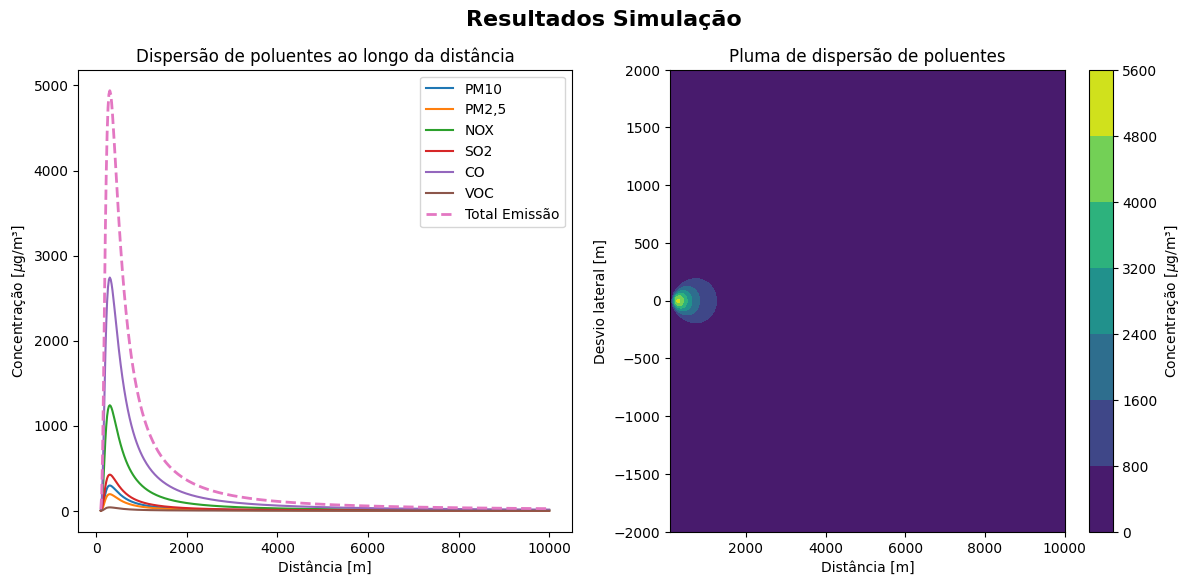

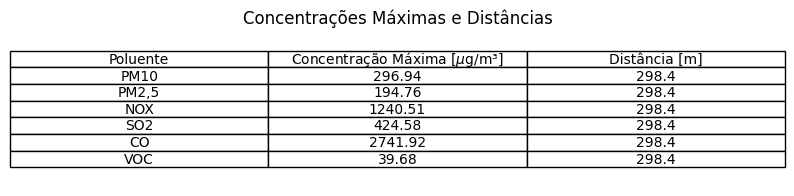

In [304]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 50,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

## Utilizando os dados obtidos nas atividades anteriores

Tomando como base a taxa de emissão calculada no trabalho 1, será simulado uma série alturas de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491.

## O primeiro teste

Condição de atmosfera instável, com classificação de Pasquill D. Altura de chaminé 50 m.


Resultados Simulação
Classe de Estabilidade: D
A pluma caiu
Sobrelevação da pluma (Briggs): 15.63 m


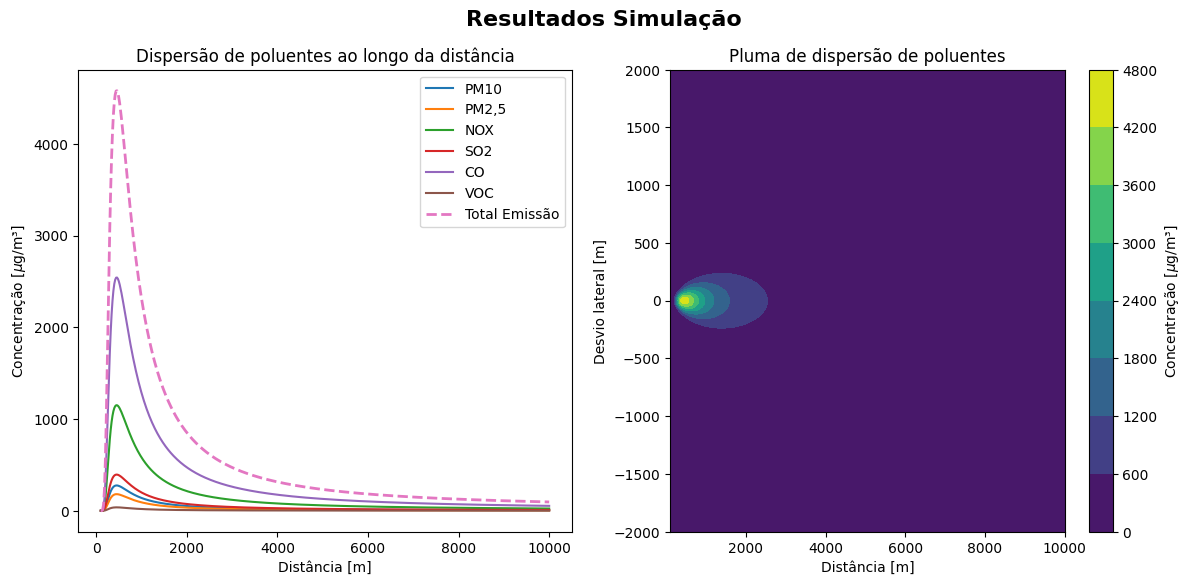

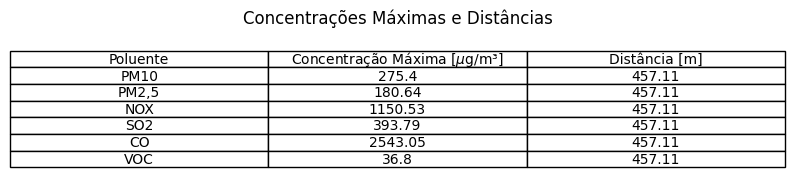

In [310]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 50,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

# Análise dos resultados do primeiro teste:

Para a classe de Pasquill D e H = 50m, as concentrações ficam muito intensos, necessitando mudanças estruturais no sistema de tratamento de gases e/ou na estrutura da indústria.

## O segundo teste

Mesmas alturas de chaminé mas a Classe de Pasquill é E, passando a condição atmosférica de instável para estável.


Resultados Simulação
Classe de Estabilidade: E
A pluma caiu
Sobrelevação da pluma (Briggs): 9.02 m


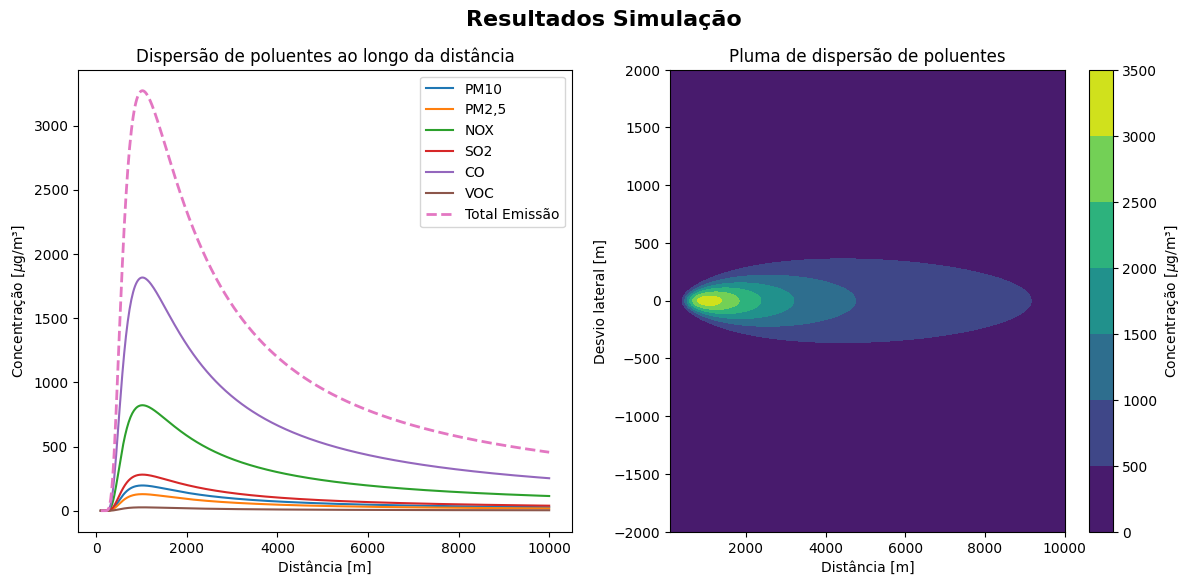

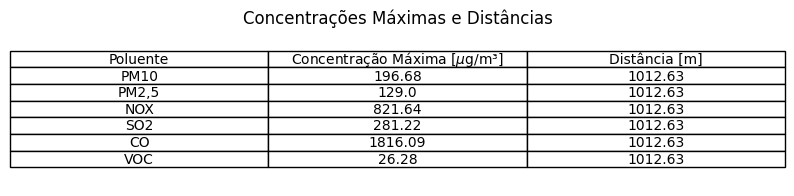

In [324]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 50,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

## Análise dos resultados do segundo teste:

Para a classe de Pasquill E e H = 50m, as concentrações seguem muito intensos, mas menores que as apresentadas no primeiro teste, no entanto, mantem-se a necess9dade de realizar mudanças estruturais no sistema de tratamento de gases e/ou na estrutura da indústria.

## O terceiro teste

Altura de chaminé é aumentada significativamente para 200 m, e a condição de Pasquill é D, pois é menos favorável que as demais categorias, deste modo, utiliza-se a pior condição para avaliar a mudança estrutural na idustria.


Resultados Simulação
Classe de Estabilidade: D
A pluma caiu
Sobrelevação da pluma (Briggs): 15.63 m


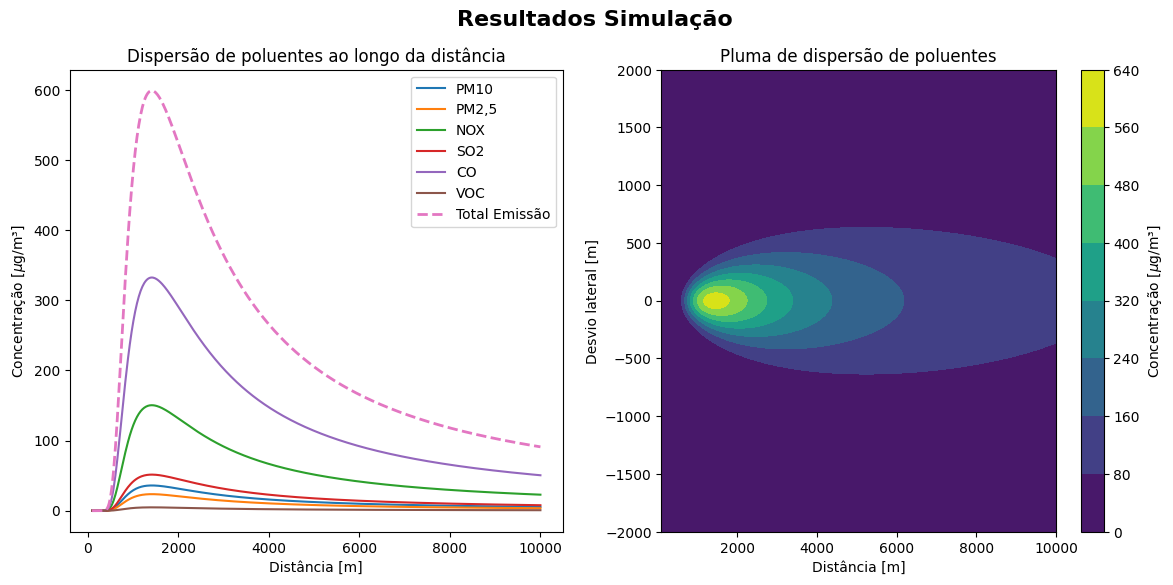

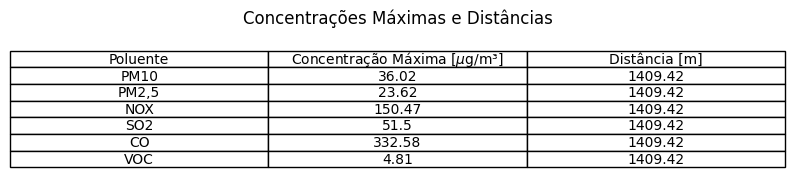

In [325]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 200,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

## Análise dos resultados do terceiro teste:

Para a classe de Pasquill D e H = 200m, as concentrações reduziram consideravelmente, enquadrando alguns poluntes nos respectivos limites da norma, no entanto, poluentes NOx seguem acima, portanto, é necessário realizar mudanças no sistema de tratamento de gases para alcançar os valores requisitados.

## Para se adequar à CONAMA 491

Dado os parâmetros e padrões abaixo, a forma de atender às legislações vigentes sem inserir mecanismos de tratamento de gases é com uma chaminé de, ao menos, 450 m de altura.

Material Particulado (PM10):
Média anual: 40 µg/m³
Média de 24 horas: 120 µg/m³

Material Particulado Fino (PM2.5):
Média anual: 20 µg/m³
Média de 24 horas: 60 µg/m³

Dióxido de Enxofre (SO2):
Média de 24 horas: 20 µg/m³
Média de 1 hora: 500 µg/m³

Óxidos de Nitrogênio (NOx), particularmente o Dióxido de Nitrogênio (NO2):
Média anual: 40 µg/m³
Média de 1 hora: 200 µg/m³

Monóxido de Carbono (CO):
Média de 8 horas: 9 ppm (10.000 µg/m³)
Média de 1 hora: 35 ppm (40.000 µg/m³)

Compostos Orgânicos Voláteis (VOC):
Não há um valor específico para todos os VOCs, pois são um grupo amplo de substâncias. No entanto, para alguns VOCs específicos como o benzeno, a recomendação é não exceder 5 µg/m³ em média anual.


Resultados Simulação
Classe de Estabilidade: D
A pluma caiu
Sobrelevação da pluma (Briggs): 15.63 m


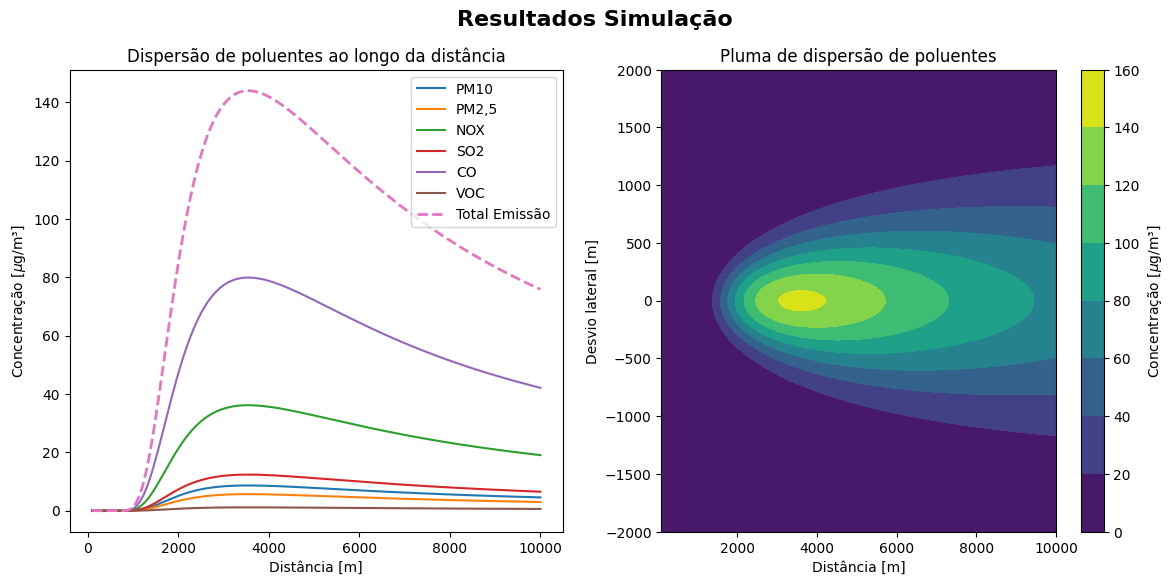

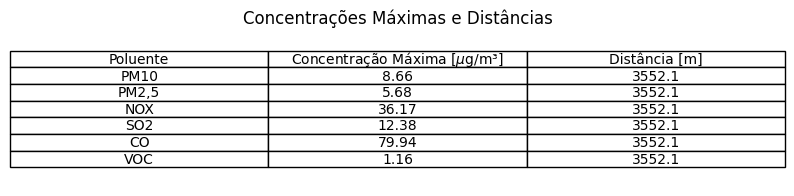

In [327]:
# Parâmetros de entrada para a simulação
params = {
    'u': 5,                     # m/s
    'y': 0,                     # estimando na direção do vento
    'z': 1.5,                   # altura do nariz
    'H': 450,                   # m
    'urbOrRural': 'urbano',
    'rc': lambda d: d / 2,      # raio da chaminé
    'd': 3.5,                   # Diâmetro da chaminé
    'Vs': 20,                   # Velocidade de saída do gás
    'p': 1013,                  # Pressão atmosférica em hPa
    'deltaT': 60,               # Diferença de temperatura entre a pluma e o ambiente
    'Ts': 533,                  # Temperatura de saída da pluma
    'Ta': lambda deltaT, Ts: Ts-deltaT,      # Temperatura Atmosférica
    'x': np.linspace(100, 10000, 500)      # Distância
}

# Calcular Fb e Fm
Ta_value = params['Ta'](params['deltaT'], params['Ts'])
params['Fb'] = calcular_fb(Ta_value, params['Ts'], params['rc'](params['d']), params['Vs'])
params['Fm'] = calcular_fm(params['Vs'], params['d'], Ta_value, params['Ts'])

# Carregar os dados dos poluentes
poluentes_df = pd.read_csv(r'C:\Users\Dell\OneDrive\Documentos\GitHub\Polatm_RamonVieira\inputs\Emissao\qs_ArcelorMittalVega.csv', header=None, skiprows=1)
poluentes_df.columns = ['poluente', 'emissao']

# Calcular a somatória das emissões
poluentes_df['total_qs'] = poluentes_df['emissao'].sum()

# Simulação com os parâmetros definidos
row = medias_diarias.sample(1).iloc[0]
classe = row['classe_estabilidade']
velocidade_vento = row['wind speed (m/s)']
fluxo_calor_sensivel = row['sensible heat flux (W/m2)']
cobertura_nuvens = row['cloud cover (tenths)']

print(f"\n{'='*40}\nResultados Simulação\n{'='*40}")
print(f"Classe de Estabilidade: {classe}")

# Ajustar a altura da chaminé com base no efeito downwash
H_adjusted = hg_tip_downwash(params['H'], params['d'], params['Vs'], params['u'])

## Davidson-Bryant
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoDavidsonBryant(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'])
# H_eff = params['H'] + deltaH

## Holland
# sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
# deltaH = sobrelevacaoHolland(params['d'], params['Vs'], params['u'], params['deltaT'], params['Ts'], params['p'])
# H_eff = params['H'] + deltaH

# Briggs
sigmaY, sigmaZ = sigmaYZ(params['x'], classe, params['urbOrRural'])
deltaH = sobrelevacaoBriggs(params['Fb'], params['Fm'], params['Vs'], params['d'], params['u'], params['deltaT'], params['Ts'], H_adjusted, classe)
H_eff = H_adjusted + deltaH

print(f"Sobrelevação da pluma (Briggs): {deltaH:.2f} m")

# Criar figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Resultados Simulação', fontsize=16, fontweight='bold')

# Inicializar lista para armazenar os dados de concentração máxima
max_concentrations = []

# Plotar gráfico de linha para cada poluente e a somatória
for poluente, valor in zip(poluentes_df['poluente'], poluentes_df['emissao']):
    qs = valor  # Usar o valor do poluente atual
    conc = modeloGaussiano(qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
    ax1.plot(params['x'], conc, label=f'{poluente}')
    
    # Encontrar concentração máxima e distância
    max_conc = np.max(conc)
    max_dist = params['x'][np.argmax(conc)]
    max_concentrations.append((poluente, max_conc, max_dist))

# Plotar a somatória das emissões
total_qs = poluentes_df['total_qs'].iloc[0]
conc_total = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], params['y'], params['z'], H_eff)
ax1.plot(params['x'], conc_total, label='Total Emissão', linestyle='--', linewidth=2)

ax1.set_xlabel('Distância [m]')
ax1.set_ylabel('Concentração [$\mu$g/m³]')
ax1.set_title('Dispersão de poluentes ao longo da distância')
ax1.legend()

# Gráfico de contorno para a somatória das emissões
X, Y = np.meshgrid(params['x'], np.linspace(-2000, 2000, 500))
sigmaY, sigmaZ = sigmaYZ(X, classe, params['urbOrRural'])
conc2D = modeloGaussiano(total_qs, sigmaY, sigmaZ, params['u'], Y, params['z'], H_eff)

contour = ax2.contourf(X, Y, conc2D, cmap='viridis')
fig.colorbar(contour, ax=ax2, label='Concentração [$\mu$g/m³]')
ax2.set_xlabel('Distância [m]')
ax2.set_ylabel('Desvio lateral [m]')
ax2.set_title('Pluma de dispersão de poluentes')

plt.show()

# Criar DataFrame com as concentrações máximas e arredondar para 2 casas decimais
max_conc_df = pd.DataFrame(max_concentrations, columns=['Poluente', 'Concentração Máxima [$\mu$g/m³]', 'Distância [m]'])
max_conc_df = max_conc_df.round(2)

# Plotar a tabela de concentrações máximas
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=max_conc_df.values, colLabels=max_conc_df.columns, cellLoc='center', loc='center')
plt.title('Concentrações Máximas e Distâncias')
plt.show()

## Análise dos resultados do teste visando o atendimento dos dados normativos:

Para atender os padrões da CONAMA 491 sem realizar tratamento dos gases, é necessário uma chaminé demasiadamente alta, algo totalmente inviável de se construir, portanto, para esta situação, recomenda-se manter a altura da chaminé por volta de 150m - 200m e immplantar mecanismos de tratamento dos gases emitidos, como filtros de mangas, separadores ciclônicos, eletrofiltros, redutores catalíticos seletivos (SCR), sistemas de injeção de amônia, oxidadores térmicos, catalisadores de oxidação, sistemas de adsorção, oxidadores regenerativos (RTOs), lavadores de gases (scrubbers), sistemas de adsorção seca, precipitadores eletrostáticos e processos de precipitação química.